In [1]:
base_url = "..//dataset//"

# Loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.pandas.set_option('display.max_columns',None)
import seaborn as sns
import scipy.stats as stat
import pylab 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import joblib
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import scipy.stats as stat
import pylab 

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve

# Agenda:

1. Get optimal threshold for doing classification
2. Clustering (Skipping for now as already getting very good results)
3. Test different models
4. Hyperparameter Tuning

# Loading the Data

In [4]:
df = pd.read_csv(base_url+'phishing_full.csv')

In [5]:
top_features = ['directory_length', 'time_domain_activation', 'length_url',
       'file_length', 'qty_slash_url', 'qty_plus_directory', 'domain_length',
       'qty_vowels_domain', 'qty_asterisk_directory', 'qty_hyphen_directory',
       'qty_dot_domain', 'qty_underline_directory', 'qty_percent_directory',
       'qty_dot_url', 'qty_hyphen_url', 'qty_hyphen_file', 'qty_hyphen_domain',
       'params_length', 'qty_underline_url', 'qty_tld_url', 'qty_plus_params',
       'qty_percent_url', 'qty_equal_params', 'qty_dot_params',
       'qty_percent_params', 'qty_underline_params']
top_features.append('phishing')

In [6]:
df = df[top_features]

In [7]:
df

,directory_length,time_domain_activation,length_url,file_length,qty_slash_url,qty_plus_directory,domain_length,qty_vowels_domain,qty_asterisk_directory,qty_hyphen_directory,qty_dot_domain,qty_underline_directory,qty_percent_directory,qty_dot_url,qty_hyphen_url,qty_hyphen_file,qty_hyphen_domain,params_length,qty_underline_url,qty_tld_url,qty_plus_params,qty_percent_url,qty_equal_params,qty_dot_params,qty_percent_params,qty_underline_params,phishing
0,8,-1,25,7,1,0,17,4,0,0,2,0,0,3,0,0,0,-1,0,1,-1,0,-1,-1,-1,-1,1
1,42,579,223,9,3,0,16,5,0,0,2,0,0,5,0,0,0,165,1,3,0,0,3,0,0,1,1
2,1,-1,15,0,1,0,14,3,0,0,2,0,0,2,0,0,0,-1,0,1,-1,0,-1,-1,-1,-1,0
3,62,-1,81,9,5,0,19,7,0,0,2,2,0,4,0,0,0,-1,2,1,-1,0,-1,-1,-1,-1,1
4,-1,6998,19,-1,0,-1,19,5,-1,-1,2,-1,-1,2,0,-1,0,-1,0,1,-1,0,-1,-1,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,-1,5509,23,-1,0,-1,23,5,-1,-1,3,-1,-1,3,1,-1,1,-1,0,2,-1,0,-1,-1,-1,-1,0
88643,-1,5046,34,-1,0,-1,34,14,-1,-1,2,-1,-1,2,0,-1,0,-1,0,1,-1,0,-1,-1,-1,-1,0
88644,48,1844,70,11,5,0,22,6,0,1,1,0,0,2,1,0,0,-1,0,1,-1,0,-1,-1,-1,-1,1
88645,1,-1,28,0,1,0,27,5,0,0,2,0,0,2,0,0,0,-1,0,1,-1,0,-1,-1,-1,-1,1


# Transformation Classes

In [8]:
import scipy.stats as stat
import pylab 

class box_cox_transformation(BaseEstimator, TransformerMixin):
    
    def __init__(self, features, flag):
        self.features = features
        self.flag = flag
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X,y=None):
        #df = X.copy()
        if not self.flag:
            return X
        
        for feature in self.features:
            try:
                # Apply box cox transformations
                X[feature], parameter = stat.boxcox(X[feature])
                print(X[feature])
            except:
                pass
        return X
            
        

In [9]:
preprocess_pipeline = joblib.load('preprocess_pipeline.joblib')

In [10]:
preprocess_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('box_cox_transformation',
                 box_cox_transformation(features=['length_url'], flag=False)),
                ('std_scaler', StandardScaler())])

# Create Train and Test Data (Using stratified Shuffle Split)

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(df, df['phishing']):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]
X_train, y_train = X_train.drop(['phishing'],axis = 1),X_train['phishing']
X_test, y_test = X_test.drop(['phishing'],axis = 1),X_test['phishing']

# Preprocessing

In [12]:
X_train = preprocess_pipeline.fit_transform(X_train)

In [13]:
X_test = preprocess_pipeline.transform(X_test)

# Selecting correct threshold

In this problem:

False Positive: Domain is not phishing but model predicted phishing

False Negative: Domain is phishing but model predicted not phishing

<strong>Clearly False Negatives are very deadly in this scenario. So I'll optimize the False Negatives and try to increase the recall</strong>

#### Using Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

In [15]:
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [16]:
train_pred = rf_model.predict_proba(X_train)

In [17]:
print('RF train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

RF train roc-auc score: 0.9988822200077919


In [18]:
# we only need the probabilities of class 1

#### Using Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=10000)

In [20]:
lr_model.fit(X_train,y_train)
train_pred = lr_model.predict_proba(X_train)

In [21]:
print('LR train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

LR train roc-auc score: 0.9756199085293384


#### Using Ada Boost

In [22]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()

In [23]:
ada_model.fit(X_train,y_train)
train_pred = ada_model.predict_proba(X_train)

In [24]:
print('ADA train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

ADA train roc-auc score: 0.9819433151064779


#### Using KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

In [26]:
knn_model.fit(X_train,y_train)
train_pred = knn_model.predict_proba(X_train)

In [27]:
print('KNN train roc-auc score: {}'.format(roc_auc_score(y_train,train_pred[:,1])))

KNN train roc-auc score: 0.9917718313506602


#### Now selecting the best threshold

In [28]:
pred = []
for model in [rf_model, lr_model,ada_model, knn_model]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))

In [29]:
final_pred = pd.concat(pred,axis = 1)

In [30]:
final_pred

,0,1,2,3
0,0.930,0.903407,0.510341,1.0
1,0.000,0.010711,0.475140,0.0
2,0.970,0.977917,0.523289,1.0
3,0.000,0.002060,0.460565,0.0
4,1.000,0.999999,0.542273,1.0
...,...,...,...,...
17725,0.000,0.002321,0.460565,0.0
17726,0.970,0.936896,0.509331,1.0
17727,0.055,0.019468,0.489351,0.0
17728,0.400,0.226266,0.497768,0.4


In [31]:
final_pred = pd.concat(pred,axis = 1).mean(axis=1)

In [32]:
final_pred

0        0.835937
1        0.121463
2        0.867801
3        0.115656
4        0.885568
           ...   
17725    0.115721
17726    0.854057
17727    0.140955
17728    0.381009
17729    0.889946
Length: 17730, dtype: float64

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, final_pred)

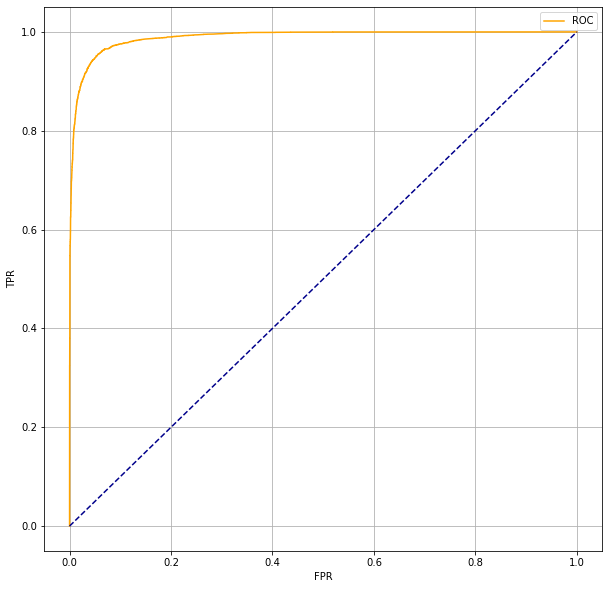

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, final_pred)
figure = plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0,1],[0,1], color='darkblue', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [35]:
from sklearn.metrics import precision_recall_curve

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test,final_pred)


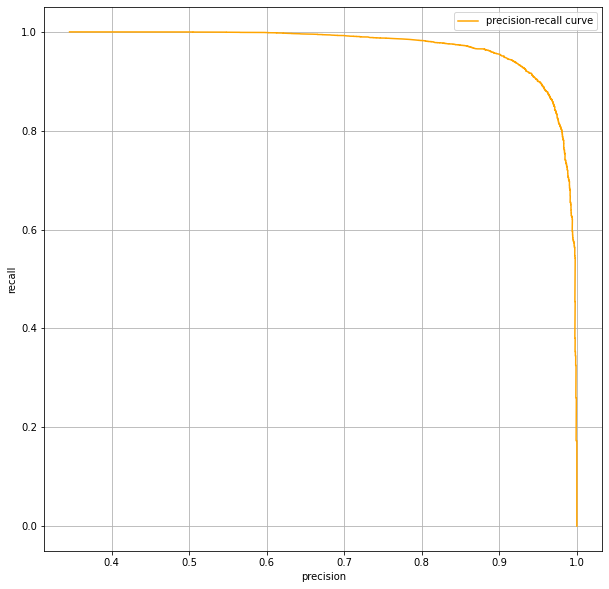

In [37]:
figure = plt.figure(figsize=(10,10))
plt.plot(precision, recall, color='orange', label='precision-recall curve')
#plt.plot([0,1],[0,1], color='darkblue', linestyle='--')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend()
plt.grid()
plt.show()

## There is a steep fall in recall at 0.8 precision. We can select that threshold

In [38]:
def get_threshold_with_precision(precisions, thresholds, min_desired_precision):
    for index, precision in enumerate(precisions):
        if precision>=min_desired_precision:
            return thresholds[index]

In [39]:
get_threshold_with_precision(precision,thresholds,0.8)

0.22390243731792225

## We will use 0.225 as the threshold so that recall is high and False Negatives can be reduced

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
rf = RandomForestClassifier()

In [42]:
rf.fit(X_train,y_train)

RandomForestClassifier()

#### Clearly False Negatives are quite less

### With 0.5 as threshold

In [43]:
predictions = rf.predict(X_test)

In [44]:
confusion_matrix(y_test,predictions)

array([[11184,   416],
       [  396,  5734]], dtype=int64)

### With custom threshold

In [45]:
probalities = rf.predict_proba(X_test)[:,1]

In [46]:
predictions = np.where(probalities>0.225,1,0)

In [47]:
confusion_matrix(y_test,predictions)

array([[10737,   863],
       [  186,  5944]], dtype=int64)

### Here: 

1. TN: 10746
2. TP: 5944
3. FP: 854
4. FN: 186

## Clearly with this threshold, we have reduced the False Negatives

In [48]:
custom_threshold = 0.225

# Testing Different models

#### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
lr = LogisticRegression(max_iter=10000)

In [51]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [52]:
predictions = lr.predict_proba(X_test)[:,1]

In [53]:
predictions = np.where(predictions>custom_threshold,1,0)

In [54]:
confusion_matrix(y_test,predictions)

array([[10131,  1469],
       [  228,  5902]], dtype=int64)

In [55]:
roc_auc_score(y_test,predictions)

0.9180839708612253

In [56]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     11600
           1       0.80      0.96      0.87      6130

    accuracy                           0.90     17730
   macro avg       0.89      0.92      0.90     17730
weighted avg       0.92      0.90      0.91     17730



#### KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier()

In [59]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [60]:
predictions = knn.predict_proba(X_test)[:,1]

In [61]:
predictions = np.where(predictions>custom_threshold,1,0)

In [62]:
confusion_matrix(y_test,predictions)

array([[10875,   725],
       [  330,  5800]], dtype=int64)

In [63]:
roc_auc_score(y_test,predictions)

0.9418331973898858

In [64]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11600
           1       0.89      0.95      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.94      0.94     17730
weighted avg       0.94      0.94      0.94     17730



#### Random Forest

In [65]:
rf = RandomForestClassifier()

In [66]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [67]:
predictions = rf.predict_proba(X_test)[:,1]

In [68]:
predictions = np.where(predictions>custom_threshold,1,0)

In [69]:
confusion_matrix(y_test,predictions)

array([[10731,   869],
       [  184,  5946]], dtype=int64)

In [70]:
roc_auc_score(y_test,predictions)

0.9475349468414243

In [71]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11600
           1       0.87      0.97      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.95      0.94     17730
weighted avg       0.94      0.94      0.94     17730



#### Extra Trees Classifier

In [72]:
from sklearn.ensemble import ExtraTreesClassifier

In [73]:
extra = ExtraTreesClassifier()

In [74]:
extra.fit(X_train,y_train)

ExtraTreesClassifier()

In [75]:
predictions = extra.predict_proba(X_test)[:,1]

In [76]:
predictions = np.where(predictions>custom_threshold,1,0)

In [77]:
confusion_matrix(y_test,predictions)

array([[10756,   844],
       [  200,  5930]], dtype=int64)

In [78]:
roc_auc_score(y_test,predictions)

0.9473074759520729

In [79]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11600
           1       0.88      0.97      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.95      0.94     17730
weighted avg       0.94      0.94      0.94     17730



#### Ada Boost

In [80]:
from sklearn.ensemble import AdaBoostClassifier

In [81]:
ada = AdaBoostClassifier()

In [82]:
ada.fit(X_train,y_train)

AdaBoostClassifier()

In [83]:
predictions = ada.predict_proba(X_test)[:,1]

In [84]:
predictions = np.where(predictions>custom_threshold,1,0)

In [85]:
confusion_matrix(y_test,predictions)

array([[    0, 11600],
       [    0,  6130]], dtype=int64)

In [86]:
roc_auc_score(y_test,predictions)

0.5

In [87]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11600
           1       0.35      1.00      0.51      6130

    accuracy                           0.35     17730
   macro avg       0.17      0.50      0.26     17730
weighted avg       0.12      0.35      0.18     17730



C:\Users\rachi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rachi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rachi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Gradient Boost

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

In [89]:
gradient_clf = GradientBoostingClassifier()

In [90]:
gradient_clf.fit(X_train,y_train)

GradientBoostingClassifier()

In [91]:
predictions = gradient_clf.predict_proba(X_test)[:,1]

In [92]:
predictions = np.where(predictions>custom_threshold,1,0)

In [93]:
confusion_matrix(y_test,predictions)

array([[10388,  1212],
       [  165,  5965]], dtype=int64)

In [94]:
roc_auc_score(y_test,predictions)

0.934300219384598

In [95]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     11600
           1       0.83      0.97      0.90      6130

    accuracy                           0.92     17730
   macro avg       0.91      0.93      0.92     17730
weighted avg       0.93      0.92      0.92     17730



#### Naive Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB

In [97]:
nb = GaussianNB()

In [98]:
nb.fit(X_train,y_train)

GaussianNB()

In [99]:
predictions = nb.predict_proba(X_test)[:,1]

In [100]:
predictions = np.where(predictions > custom_threshold,1,0)

In [101]:
predictions

array([0, 0, 1, ..., 1, 0, 1])

In [102]:
confusion_matrix(y_test,predictions)

array([[11072,   528],
       [ 2598,  3532]], dtype=int64)

In [103]:
roc_auc_score(y_test,predictions)

0.7653327333070822

In [104]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     11600
           1       0.87      0.58      0.69      6130

    accuracy                           0.82     17730
   macro avg       0.84      0.77      0.78     17730
weighted avg       0.83      0.82      0.81     17730



#### XG Boost

In [105]:
from xgboost import XGBClassifier

In [106]:
xgb = XGBClassifier()

In [107]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [108]:
predictions = xgb.predict_proba(X_test)[:,1]

In [109]:
predictions = np.where(predictions>custom_threshold,1,0)

In [110]:
confusion_matrix(y_test,predictions)

array([[10730,   870],
       [  181,  5949]], dtype=int64)

In [111]:
roc_auc_score(y_test,predictions)

0.9477365415986951

In [112]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11600
           1       0.87      0.97      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.95      0.94     17730
weighted avg       0.95      0.94      0.94     17730



#### XGBRF classifier

In [113]:
from xgboost import XGBRFClassifier

In [114]:
xgbrf = XGBRFClassifier()

In [115]:
xgbrf.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='', max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                sampling_method='uniform', scale_pos_weight=1, ...)

In [116]:
predictions = xgbrf.predict_proba(X_test)[:,1]

In [117]:
predictions = np.where(predictions>custom_threshold,1,0)

In [118]:
confusion_matrix(y_test,predictions)

array([[10357,  1243],
       [  165,  5965]], dtype=int64)

In [119]:
roc_auc_score(y_test,predictions)

0.9329640124880463

In [120]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94     11600
           1       0.83      0.97      0.89      6130

    accuracy                           0.92     17730
   macro avg       0.91      0.93      0.92     17730
weighted avg       0.93      0.92      0.92     17730



# On high level testing, Random Forests and XG Boost seem to be giving best results

# Hyperparameter tuning

In [121]:
rf = RandomForestClassifier()

In [122]:
parameters = {
    'n_estimators':[100,200,500,1000],
    'criterion':["gini", "entropy", "log_loss"],
    'min_samples_split':[2,4,6],
    'max_features':['int','sqrt','log2'],
    'bootstrap':[True,False],
    
}

In [123]:
from sklearn.model_selection import GridSearchCV

In [140]:
grid = GridSearchCV(rf, parameters,cv=3,verbose=10,n_jobs=-1, scoring='recall')

In [141]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\rachi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rachi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rachi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\rachi\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\rachi\anaconda3\lib\site-packages

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['int', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='recall', verbose=10)

In [142]:
best_estimator = grid.best_estimator_

In [143]:
predictions = best_estimator.predict_proba(X_test)[:,1]

In [144]:
predictions = np.where(predictions>custom_threshold,1,0)

In [145]:
confusion_matrix(y_test,predictions)

array([[10656,   944],
       [  168,  5962]], dtype=int64)

In [146]:
roc_auc_score(y_test,predictions)

0.9456072453169826

In [147]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11600
           1       0.86      0.97      0.91      6130

    accuracy                           0.94     17730
   macro avg       0.92      0.95      0.93     17730
weighted avg       0.94      0.94      0.94     17730



In [148]:
best_estimator

RandomForestClassifier(max_features='log2', min_samples_split=6,
                       n_estimators=500)

## We will use this estimator

estimator: RandomForestClassifier <br>
max_features: log2 <br>
min_samples_split : 6 <br>
n_estimators: 500


### Let's just see on training dataset as well

In [152]:
predictions_train = best_estimator.predict_proba(X_train)[:,1]

In [153]:
predictions_train = np.where(predictions_train>custom_threshold,1,0)

In [154]:
confusion_matrix(y_train,predictions_train)

array([[43657,  2743],
       [  201, 24316]], dtype=int64)

In [155]:
print(classification_report(y_train,predictions_train))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     46400
           1       0.90      0.99      0.94     24517

    accuracy                           0.96     70917
   macro avg       0.95      0.97      0.96     70917
weighted avg       0.96      0.96      0.96     70917

